In [1]:
import os
import sys
import cv2
import pickle
import pygame
import librosa
import logging
import numpy as np
import pandas as pd
import sounddevice as sd
from PIL import Image
from joblib import load
from numpy.lib import stride_tricks
import scipy.io.wavfile as wav 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvus
from matplotlib.backends.backend_qt5agg import NavigationToolbar2QT as NavigationToolbar
from python_speech_features import mfcc

from PyQt5 import QtGui
from PyQt5.QtGui import QIcon, QFont
from PyQt5.QtCore import Qt
from PyQt5.QtWidgets import (QApplication, QWidget, QToolTip, QFileDialog,QButtonGroup, QLabel,
                             QRadioButton, QComboBox, QLineEdit, QPushButton, QGridLayout, QPlainTextEdit)

from keras.models import load_model, model_from_json


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


Using TensorFlow backend.


In [2]:
""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.8, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)   
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win

    return np.fft.rfft(frames)

""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]

    return newspec, freqs

""" get spectrogram"""
def getSpectrogram(samples, samplerate, binsize=400):
    s = stft(samples, binsize)
    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)
    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel
#     ims = Image.fromarray(ims).resize((50,100), Image.BICUBIC)
#     image = np.asarray(ims)
#     norm = plt.Normalize()
#     image = plt.cm.jet(norm(image.T))
#     img = image[::-1, :, :3]
    norm = plt.Normalize()
    colors = plt.cm.jet(norm(ims.T))
    colors = colors[::-1,:,:3]
    img = cv2.resize(colors, (100, 50))    
    return img


In [3]:
wt,ht = 1200,600

class QPlainTextEditLogger(logging.Handler):
    def __init__(self, parent):
        super().__init__()
        self.widget = QPlainTextEdit(parent)
        self.widget.setReadOnly(True)

    def emit(self, record):
        msg = self.format(record)
        self.widget.appendPlainText(msg)

class Window(QWidget): #inherits from the QWidget class. QWidget widget is the base class of all user interface objects in PyQt5.

    def __init__(self):
        super().__init__() #super() method returns the parent object of the Window class and we call its constructor. 
        self.initUI()

    def initUI(self):
        #Labeling Widgets
        modelSelect = QLabel(' Select Classfication Model:')
        frameResult = QLabel(' Frame-wise Prediction Result:')
        self.timeBegin = QLabel()
        self.timeEnd = QLabel()
        self.modelShowLabel = QLabel(self)
        self.modelShowLabel.setAlignment(Qt.AlignCenter)
        self.rates = ['16000', '44100']
        self.models = ['DNN (resnet50)', 'SVM with MFCC']
        self.modelFiles = ['resnet_model_m1.json', 'svm_mfcc_500ms.pkl']
        self.modelWeights = ['resnet_model_w1.h5', 'svm']
        self.classes = ['Not-faulty', 'Faulty', 'Silence']
        self.frameOverlap = QLabel()
        self.frameOverlap.setAlignment(Qt.AlignCenter)
        self.frames = ['2000', '500']
        self.olap = ['75', '75']
        self.boldFont = QFont()
        self.boldFont.setBold(True)
        self.regFont = QFont()
        self.regFont.setBold(False)
        pygame.init()
        
        self.logTextBox = QPlainTextEditLogger(self)
        self.logTextBox.setFormatter(logging.Formatter('>> %(message)s'))
        logging.getLogger().addHandler(self.logTextBox)
        logging.getLogger().setLevel(logging.INFO)
        
        #Implementing Those Widgets
        self.fsEdit = QComboBox()
        self.timeDuration = QLabel(" Time Duration: ")
        self.timeDuration.setAlignment(Qt.AlignVCenter|Qt.AlignLeft)
        self.loadAudio = QPushButton("Load Audio")
        self.playAudio = QPushButton("Play Frame Audio")
        self.plotAudio = QPushButton("Plot Audio")
        self.plotSpectro = QPushButton("Plot Spectrogram")
        self.figure = plt.figure(figsize=(4,2), dpi=100)
        self.canvas = FigureCanvus(self.figure)
        self.toolbar = NavigationToolbar(self.canvas,self)
        self.importModel = QPushButton("Load Model")
        self.generateData = QPushButton("Generate Data")
        self.doPrediction = QPushButton("Do Prediction")
        self.modelSelect = QComboBox() # Model Selection
        self.modelGraph = QComboBox()
        self.Show = QPushButton("Show")
        self.predictionResult = QLabel(" Pred Result:")
        self.predictionResult.setAlignment(Qt.AlignVCenter|Qt.AlignLeft)
        self.back = QPushButton("<<")
        self.timeBegin = QLineEdit("")
        self.timeBegin.setReadOnly(True)
        self.timeBegin.setAlignment(Qt.AlignCenter)
        self.frameResult = QLineEdit("", readOnly=True)
        self.frameResult.setReadOnly(True)
        self.frameResult.setAlignment(Qt.AlignCenter)
        self.timeEnd = QLineEdit("")
        self.timeEnd.setAlignment(Qt.AlignCenter)
        self.timeEnd.setReadOnly(True)
        self.front = QPushButton(">>")
        self.freqAxis = np.arange(-1600,8001,1600)
        self.timeAxis = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

        self.fsEdit.addItem('Select Fs (in Hz)')
        for srate in self.rates:
            self.fsEdit.addItem(srate)

        for model in self.models:
            self.modelSelect.addItem(model)

        #self.modelGraph.addItem('Model Plot')
        self.modelGraph.addItem('K-Fold Cross Validation Scores')
        self.modelGraph.addItem('Learning Curves')
        self.modelGraph.addItem('Confusion Matrix of Holdout Data')

        #Setting Layout
        grid = QGridLayout()
        grid.setSpacing(10)

        #1st Row
        nRow = 1
        grid.addWidget(self.fsEdit, nRow, 0, 1, 2)
        grid.addWidget(self.loadAudio, nRow, 2, 1, 2)
        grid.addWidget(self.plotAudio, nRow, 4, 1, 2)
        grid.addWidget(self.plotSpectro, nRow, 6, 1, 2)
        grid.addWidget(self.logTextBox.widget, nRow, 8, 2, 4)

        #2nd Row
        nRow += 1
        grid.addWidget(self.timeDuration, nRow, 0, 1, 2)
        grid.addWidget(self.playAudio, nRow, 2, 1, 2)
        grid.addWidget(self.toolbar, nRow, 4, 1, 4)

        #3rd Row
        nRow += 1
        grid.addWidget(self.canvas, nRow, 0, 1, 8)
        grid.addWidget(self.modelShowLabel, nRow, 8, 1, 4)

        #4th Row
        nRow += 1
        grid.addWidget(modelSelect, nRow, 0, 1, 2)
        grid.addWidget(self.modelSelect, nRow, 2, 1, 2)
        grid.addWidget(self.frameOverlap, nRow, 4, 1, 2)
        grid.addWidget(self.importModel, nRow, 6, 1, 2)
        grid.addWidget(self.modelGraph, nRow, 8, 1, 4)

        #5th Row
        nRow += 1
        grid.addWidget(self.predictionResult, nRow, 0, 1, 4)
        grid.addWidget(self.generateData, nRow, 4, 1, 2)
        grid.addWidget(self.doPrediction, nRow, 6, 1, 2)
        grid.addWidget(self.Show, nRow, 8, 1, 4)

        #6th Row
        nRow += 1
        grid.addWidget(frameResult, nRow, 0, 1, 2)
        grid.addWidget(self.back, nRow, 2, 1, 1)
        grid.addWidget(self.timeBegin, nRow, 3, 1, 1)
        grid.addWidget(self.frameResult, nRow, 4, 1, 2)
        grid.addWidget(self.timeEnd, nRow, 6, 1, 1)
        grid.addWidget(self.front, nRow, 7, 1, 1)
        
        for col in range(0,grid.columnCount()):
            grid.setColumnStretch(col, 1)
        
        self.setLayout(grid)

        self.loadAudio.clicked.connect(self.load)
        self.plotAudio.clicked.connect(self.plot)
        self.playAudio.clicked.connect(self.playFrameAudio)
        self.plotSpectro.clicked.connect(self.plotSpectrogram)

        self.modelSelect.currentIndexChanged.connect(self.setModelInfo)
        self.importModel.clicked.connect(self.loadModel)
        self.generateData.clicked.connect(self.generate)
        self.doPrediction.clicked.connect(self.predict)
        self.Show.clicked.connect(self.modelShow)
        self.back.clicked.connect(self.left)
        self.front.clicked.connect(self.right)

        #locates the window on the screen and sets it size(x,y,x+w,y+d)                
        self.setGeometry(200, 200, 200+wt, 200+ht)
        self.setWindowTitle('GUI')
        #self.show(QIcon('FileName.png'))
        self.initVar()
        self.show()
        self.setModelInfo()

    def initVar(self):
        self.figure.clear()
        self.plotAudio.setEnabled(False)
        self.playAudio.setEnabled(False)
        self.plotSpectro.setEnabled(False)
        self.generateData.setEnabled(False)
        self.doPrediction.setEnabled(False)
        self.back.setEnabled(False)
        self.front.setEnabled(False)
        self.audioBlocks = np.array([])
        self.audioMFCC = np.array([])
        self.indices = np.array([])
        self.wavFile = np.array([])
        self.spectroData = np.array([])
        self.timeDuration.setFont(self.regFont)
        self.predictionResult.setFont(self.regFont)
        self.prediction = np.array([])
        self.Index = -1
        self.spectro = False
        self.predicted = False
        self.modelLoaded = False
        self.plotFull = True
    
    def setModelInfo(self):
        ind = self.modelSelect.currentIndex()
        self.frameOverlap.setText("Frame Size = "+self.frames[ind]+"ms, Overlap = "+self.olap[ind]+"%")
    
    def displayLog(self, messageLine):
        logging.info(messageLine)

    def left(self):
        self.Index -= 1
        if (self.Index == 0):
            self.back.setEnabled(False)
        elif (self.Index==self.audioBlocks.shape[0]-2):
            self.front.setEnabled(True)
        self.plotWave(True)        

    def right(self):
        self.Index += 1
        if (self.Index==self.audioBlocks.shape[0]-1):
            self.front.setEnabled(False)
        elif (self.Index==1):
            self.back.setEnabled(True)
        self.plotWave(True)
    
    def playFrameAudio(self):
        audioToPlay = self.audioBlocks[self.Index]
        sd.play(audioToPlay, self.rate)

    def playFrameResult(self, frameClass=''):
        if len(frameClass):
            pygame.mixer.music.load(frameClass + '.wav')
            pygame.mixer.music.play()

    def load(self):
        if(self.fsEdit.currentText().isdigit()):
            self.fname = QFileDialog.getOpenFileName(self,
                                                     'Open Recorded Audio',
                                                     'C:\\Users\\ASUS\\AppData\\Local\\Programs\\Python\\Python36\\BTP',
                                                     'Audio files (*.wav *.mp3)')
            self.initVar()
            fs1 = int(self.fsEdit.currentText())
            (self.wavFile, self.rate) = librosa.load(self.fname[0],sr=int(fs1),mono=True)
            if self.wavFile.dtype == 'int16':
                self.wavFile /= 32768
            else:
                self.wavFile /= 1
            self.timeDuration.setText('  Time Duration: '+str(self.wavFile.size/self.rate)+'s')
            self.timeDuration.setFont(self.boldFont)
            self.displayLog('Loaded audio file: ' + self.fname[0])
            self.plotAudio.setEnabled(True)
            self.generateData.setEnabled(True)
        else:
            self.displayLog('Please select a sampling frequency')
    
    def plot(self):
        self.spectro = False
        if (self.Index >= 0):
            if(self.plotFull):
                self.plotWave(False)
                self.playAudio.setEnabled(False)
                self.plotFull = False
            else:
                self.Index -= 1
                self.right()
                self.playAudio.setEnabled(True)
                self.plotFull = True
        else:
            self.plotWave(False)
    
    def displayFrameResult(self):
        ind = self.Index
        frameShow = 'Frame '+str(ind+1)
        if(self.predicted):
            predClass = self.classes[self.prediction[ind]]
            frameShow += ' -> '+predClass
            self.playFrameResult(predClass)
        self.frameResult.setText(frameShow)
        
    def plotWave(self, flag=False):
        self.figure.clear()
        ax = self.figure.add_subplot(111)
        ax.set_xlabel('Time in seconds')
        ax.set_title('Recorded Audio')

        if flag:
            ind = self.Index
            self.timeBegin.setText(str(ind*self.hop/self.rate)+'s')
            self.timeEnd.setText(str((ind*self.hop+self.fsize)/self.rate)+'s')
            self.displayFrameResult()

            if self.spectro:
                image = self.spectroData[ind,...]
                timeAxis = (ind*self.hop + self.timeAxis*self.fsize) / self.rate
                ax.imshow(np.flipud(image), origin="lower")
                ax.set_yticklabels(self.freqAxis)
                ax.set_xticks([0, 25, 50, 75, 99])
                ax.set_xticklabels(timeAxis)
                ax.set_ylabel("Frequency in Hz")
            else:
                time = (ind*self.hop+np.arange(0,self.fsize,dtype='int32'))/self.rate
                ax.plot(time, self.audioBlocks[self.Index,:],'b-')
                ax.set_ylim(-1, 1)
                self.canvas.draw()
        else:
            time = np.arange(1/self.rate, (len(self.wavFile)+1)/self.rate, 1/self.rate)
            ax.plot(time, self.wavFile,'b-')
            ax.set_ylim(-1, 1)
        self.canvas.draw()

    def plotSpectrogram(self):
        self.plotFull = False
        self.spectro = True
        self.plotWave(True)
        self.playAudio.setEnabled(True)
    
    def generate(self):
        self.displayLog('Generating prediction data ...')
        ind = self.modelSelect.currentIndex()
        self.fsize = int(int(self.frames[ind])/1000*self.rate)
        self.hop = self.fsize-int(int(self.olap[ind])/100*self.fsize)
        rng = int(len(self.wavFile)/self.hop - int(100 / (100-int(self.olap[ind]))) + 1)
        self.audioBlocks = np.empty((rng,self.fsize))
        for i in range(0, rng):
            self.audioBlocks[i,...] = self.wavFile[i*self.hop:i*self.hop+self.fsize]
        if ind == 0:
            self.spectroData = np.empty((rng,50,100,3))
            for i in range(0, self.audioBlocks.shape[0]):
                self.spectroData[i,...] = getSpectrogram(self.audioBlocks[i,...], self.rate)
            self.plotSpectro.setEnabled(True)
        elif ind == 1:
            En = self.audioBlocks
            En = En**2
            En = sum(En.T).T
            self.indices = En >= 20
            self.audioMFCC = np.empty((sum(self.indices), 13))
            audioBlocks = self.audioBlocks[self.indices,:]
            for i in range(0, audioBlocks.shape[0]):
                self.audioMFCC[i,:] = mfcc(signal=audioBlocks[i,:],
                                           samplerate=self.rate,
                                           winlen=0.5,
                                           winstep=0.5,
                                           nfft=8192)
        self.Index = -1
        self.right()
        self.plotFull = False
        self.playAudio.setEnabled(True)
        self.front.setEnabled(True)
        self.displayLog('Succesfully generated prediction data')
        if self.modelLoaded:
            self.doPrediction.setEnabled(True)

    def loadModel(self):
        ind = self.modelSelect.currentIndex()
        if ind == 0:
            json_file = open(self.modelFiles[ind], "r")
            loaded_model_json = json_file.read()
            json_file.close()
            self.my_model = model_from_json(loaded_model_json)
            self.my_model.load_weights(self.modelWeights[ind])
            self.modelLoaded = True
        elif ind == 1:
            self.my_model = load(self.modelFiles[ind])
            self.modelLoaded = True
        if (self.audioBlocks.size):
            self.doPrediction.setEnabled(True)
        self.displayLog('Loaded classifier: ' + self.modelSelect.currentText())
        
    def predict(self):
        if (self.modelLoaded):
            self.displayLog('Prediction in progress ...')
            ind = self.modelSelect.currentIndex()
            if ind == 0:
                my_pred = self.my_model.predict(self.spectroData)
                self.prediction = np.argmax(my_pred, axis=-1).astype('int8')
            elif ind == 1:
                self.prediction = (np.ones((self.audioBlocks.shape[0], 1)) + 1).astype('int8')
                self.prediction = self.prediction[:,0]
                indices = np.arange(0,self.indices.shape[0])
                indices = indices[self.indices]
                self.prediction[indices] = self.my_model.predict(self.audioMFCC).astype('int8')
            if self.prediction.size:
                self.predicted = True
                self.showResult()
            self.displayFrameResult()

            self.displayLog('Prediction completed')
        else:
            self.displayLog('Please load a model first')

    def showResult(self):
        countNotFaulty = sum(self.prediction==0)
        countFaulty = sum(self.prediction==1)
        ratioNF = 100*countNotFaulty/self.prediction.size
        ratioF = 100*countFaulty/self.prediction.size
        predString = 'Not-Faulty = ' + "{:.1f}".format(ratioNF) + '%, Faulty = ' + "{:.1f}".format(ratioF) + '%'
        if self.modelSelect.currentIndex() == 1:
            predString += ', Silence = ' + "{:.1f}".format((100-ratioNF-ratioF)) + '%'
        self.predictionResult.setText(' Pred Result: '+predString)

    def modelShow(self):
        ind = self.modelSelect.currentIndex()
        image_fname = 'model_info/' + self.models[ind] + '/' + self.modelGraph.currentText() + '.png'
        if os.path.exists('./'+image_fname):
            pixmap = QtGui.QPixmap('./'+image_fname)
            self.modelShowLabel.setPixmap(pixmap)#.scaled(self.modelShowLabel.size()))
        else:
            self.modelShowLabel.setText('No such graph or matrix for the model:\n'+self.models[ind])


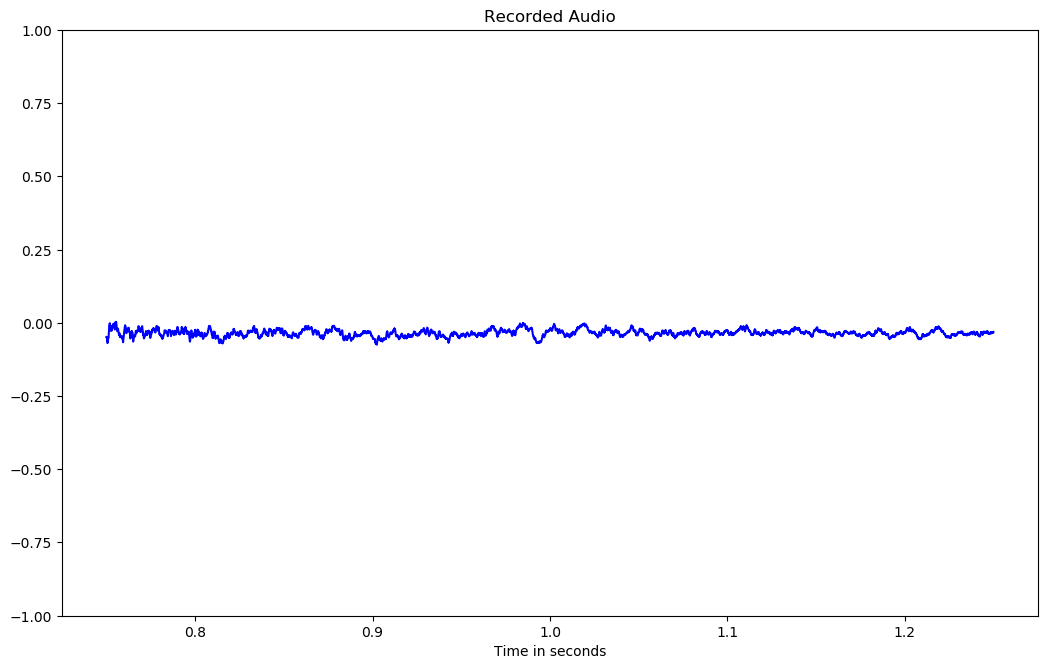

In [4]:
if __name__ == '__main__':
    app = QApplication(sys.argv) #Every PyQt5class Window(QWidget): #inherits from the QWidget class. QWidget widget is the base class of all user interface objects in PyQt5.
    window = Window()
    app.exec_() #enters the mainloop of the application. The event handling starts from this point.

    